In [1]:
from langchain_ollama import ChatOllama
from ddgs import DDGS
import time  
from langchain_core.tools import tool, Tool
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import PromptTemplate 
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Annotated, Literal
from langgraph.prebuilt import create_react_agent
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
#llm  = ChatOllama(model="deepseek-r1:8b")
#llm  = ChatOllama(model="llama3.2:3b")
#llm  = ChatOllama(model="llama3.1:8b") 
#llm  = ChatOllama(model="qwen3:4b")
llm  = ChatOllama(model="qwen3:8b")

In [3]:
class AgentState(TypedDict):
    question: str               # User question (immutable)
    draft: str                  # Initial response draft
    critique: Annotated[str, "After reflection"]  # Self-critique of draft
    refined: Annotated[str, "After refinement"]   # Final refined answer
    iterations: Annotated[int, "Refinement count"] # Track improvement cycles
    status: Literal["draft", "critique", "refined", "final"]  # Workflow stage

In [4]:
DRAFT_PROMPT = ChatPromptTemplate.from_template("""You're an AI assistant. Answer the question clearly and concisely.
<question>
{question}
</question>
Response:"""
)

In [5]:
CRITIQUE_PROMPT = ChatPromptTemplate.from_template(
    """Critique this response to the question. Identify 3 flaws: factual inaccuracies, 
lack of clarity, missing information, or poor structure. Be specific.

<question>
{question}
</question>

<draft_response>
{draft}
</draft_response>

Critique:"""
)

In [6]:
REFINE_PROMPT = ChatPromptTemplate.from_template(
    """Improve this response based on the critique. Maintain original style. 
Address all critique points.

<question>
{question}
</question>

<critique>
{critique}
</critique>

<original_response>
{draft}
</original_response>

Improved Response:"""
)

In [7]:
def generate_initial_draft(state: AgentState):
    """Node: Create initial response draft"""
    chain = DRAFT_PROMPT | llm
    response = chain.invoke({"question": state["question"]})
    return {
        "draft": response.content,
        "iterations": 0,
        "status": "draft"
    }

In [8]:
def reflect_on_draft(state: AgentState):
    """Node: Generate critique of initial draft"""
    chain = CRITIQUE_PROMPT | llm
    response = chain.invoke({
        "question": state["question"],
        "draft": state["draft"]
    })
    return {
        "critique": response.content,
        "status": "critique"
    }

In [9]:
def refine_response(state: AgentState):
    """Node: Improve draft based on critique"""
    chain = REFINE_PROMPT | llm
    response = chain.invoke({
        "question": state["question"],
        "draft": state["draft"],
        "critique": state["critique"]
    })
    return {
        "refined": response.content,
        "iterations": state["iterations"] + 1,
        "status": "refined"
    }


In [10]:
def quality_validator(state: AgentState):
    """Decision node: Determine if refinement is needed"""
    # Simple iteration-based stopping condition
    if state["iterations"] >= 2:  # Max 2 refinement cycles
        return "final"
    
    # Content-based validation (simplified)
    critique = state["critique"].lower()
    if any(term in critique for term in ["excellent", "perfect", "no issues"]):
        return "final"
    return "needs_refinement"

In [11]:
workflow = StateGraph(AgentState)
 
workflow.add_node("draft", generate_initial_draft)
workflow.add_node("critique", reflect_on_draft)
workflow.add_node("refine", refine_response)

workflow.add_edge(START, "draft")
workflow.add_edge("draft", "critique")
workflow.add_edge("critique", "refine")

workflow.add_conditional_edges(
    "refine",
    quality_validator,
    {
        "final": END,
        "needs_refinement": "critique"  # Loop back for re-critique
    }
)

agent = workflow.compile()

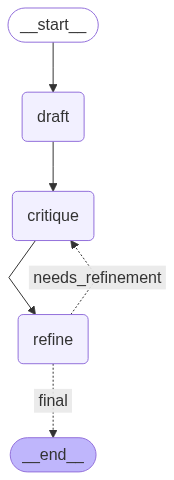

In [12]:
agent

In [13]:
def run_agent(question: str):
    """Execute the reflection agent"""
    result = agent.invoke({
        "question": question,
        "draft": "",
        "critique": "",
        "refined": "",
        "iterations": 0,
        "status": "draft"
    })
    return result

In [14]:
QUESTION = "Explain quantum entanglement in simple terms"
    
# Run the agent
final_state = run_agent(QUESTION)

# Display results
print("\n===== FINAL OUTPUT =====")
print(f"Refined Answer ({final_state['iterations']} refinements):")
print(final_state["refined"])

print("\n===== DEBUG INFO =====")
print(f"Initial Draft:\n{final_state['draft']}\n")
print(f"Critique:\n{final_state['critique']}")


===== FINAL OUTPUT =====
Refined Answer (2 refinements):
<think>
Okay, let's tackle this. The user wants the response to quantum entanglement improved based on the critique. The original response is good but has some flaws. Let me check the critique again.

First, the critique points out three issues: factual inaccuracy (implying faster-than-light communication), lack of clarity (vague terms like "state of one"), and missing information (superposition and measurement process). 

The original response mentions "instantly affects the other" which could be misinterpreted as faster-than-light communication. I need to clarify that no information is actually transmitted. 

The example uses "state of one" and "opposite property" without explaining superposition. I should mention that particles exist in a combined state until measured. 

Also, the response doesn't address the measurement process or the role of quantum states. Adding that particles are in a superposition until observed would h

## **QWEN-3:8b** [15 Minuets]

===== FINAL OUTPUT =====
Refined Answer (2 refinements):
<think>
Okay, let's tackle this. The user wants the response to quantum entanglement improved based on the critique. The original response is good but has some flaws. Let me check the critique again.

First, the critique points out three issues: factual inaccuracy (implying faster-than-light communication), lack of clarity (vague terms like "state of one"), and missing information (superposition and measurement process). 

The original response mentions "instantly affects the other" which could be misinterpreted as faster-than-light communication. I need to clarify that no information is actually transmitted. 

The example uses "state of one" and "opposite property" without explaining superposition. I should mention that particles exist in a combined state until measured. 

Also, the response doesn't address the measurement process or the role of quantum states. Adding that particles are in a superposition until observed would help. 

I should rephrase the example to include superposition and measurement. Maybe use a pair of entangled particles in a shared state, like spin-up/spin-down. When one is measured, the other's state is determined instantly, but no info is sent faster than light. 

Also, the original response is concise but could be more detailed. Adding a note about experiments confirming this and its role in quantum tech might be helpful, but the user asked for simple terms, so maybe keep it brief. 

Let me structure it: start with the link between particles, mention superposition, explain measurement affects the state, clarify no faster-than-light communication, and keep it simple. 

Check for clarity and flow. Make sure each point addresses the critique without overcomplicating. Avoid jargon but explain necessary terms. 

Okay, that should cover all the critique points while maintaining the original style.
</think>

Quantum entanglement is when two particles become linked, so the state of one instantly affects the other, no matter how far apart they are. Imagine two coins that are magically connected: if one lands heads, the other instantly lands tails, even if they’re light-years apart. This "spooky connection" (as Einstein called it) defies classical physics but is a key part of quantum mechanics. However, it’s important to note that this doesn’t allow for faster-than-light communication—no actual information is transmitted instantaneously. Instead, the particles exist in a shared quantum state (like a pair of entangled dice) until measured, at which point their states are determined. This phenomenon has been confirmed by experiments and is foundational to quantum computing and cryptography.

===== DEBUG INFO =====
Initial Draft:
<think>
Okay, the user wants me to explain quantum entanglement in simple terms. Let me start by recalling what I know. Quantum entanglement is a phenomenon where particles become linked, so the state of one instantly affects the other, no matter the distance. But how to make that simple?

First, maybe use an analogy. Like, imagine two coins that are magically connected. When you flip one, the other instantly knows the result. But wait, coins might not be the best example. Maybe something more relatable, like a pair of dice or maybe even something like a pair of gloves? Wait, the classic example is particles like electrons that have opposite spins. But I need to keep it simple.

I should mention that even if they're far apart, measuring one affects the other. But I need to avoid technical jargon. Maybe say something like "connected particles that can influence each other instantly, even if they're far apart." Also, clarify that this doesn't allow for faster-than-light communication, which is a common misconception. 

Wait, the user asked for simple terms, so maybe avoid terms like 'quantum states' or 'superposition' unless necessary. Focus on the connection and the instantaneous effect. Also, maybe mention that this is a key part of quantum mechanics and has applications in quantum computing. But keep it concise. Let me put it all together in a clear, short explanation.
</think>

Quantum entanglement is when two particles become linked, so the state of one instantly affects the other, no matter how far apart they are. For example, if one particle is measured to have a certain property (like spin), the other particle immediately adopts the opposite property, even if they’re light-years away. This "spooky connection" (as Einstein called it) defies classical physics but is a key part of quantum mechanics.

Critique:
<think>
Okay, let's see. The user asked for a critique of the response to the question about quantum entanglement. The task is to identify three flaws in the response, which could be factual inaccuracies, lack of clarity, missing information, or poor structure. Let me start by carefully reading the draft response and the question again.

The question is "Explain quantum entanglement in simple terms." The draft response uses an example of particles being linked, where measuring one affects the other instantly, even at a distance. It mentions "spooky connection" and notes it defies classical physics but is part of quantum mechanics. 

First, I need to check for factual inaccuracies. The response mentions that measuring one particle instantly affects the other. However, quantum entanglement doesn't allow for faster-than-light communication, which is a common misconception. The response doesn't address this, so that could be a factual inaccuracy. Wait, the response says it "defies classical physics" but doesn't mention that no information is actually transmitted faster than light. That's a key point. So maybe that's a missing information or a factual inaccuracy.

Second, the example given is a bit vague. The user might not understand what "state of one" means. The response doesn't clarify that entangled particles are in a superposition of states until measured. Without explaining superposition, the explanation might be incomplete. So that's a missing information or lack of clarity.

Third, the response is structured as a simple explanation but lacks depth. It doesn't mention the role of quantum states, the measurement process, or the implications of entanglement. Also, the example of "spooky connection" is a metaphor but might not convey the underlying principles clearly. The structure is okay, but maybe not detailed enough for a simple explanation. 

Wait, the user asked for simple terms, so maybe the response is too brief. Let me check again. The response is concise but might miss key points. For example, it doesn't explain that entangled particles are in a combined state, and their properties are not determined until measured. That's a major missing piece. Also, the example of particles having opposite properties (like spin) is a good start, but not elaborated. 

So, three flaws: 1. Factual inaccuracy by not addressing that no information is transmitted faster than light. 2. Lack of clarity by not explaining superposition. 3. Missing information about the combined quantum state and measurement process. Alternatively, maybe the structure is too simplistic, but the response is short. Alternatively, maybe the first point is missing information. 

I need to be specific. The response doesn't mention that entangled particles are in a superposition of states, which is a fundamental aspect. Also, it doesn't clarify that the correlation only becomes apparent upon measurement. So, those are missing information. Additionally, the response doesn't address the non-locality aspect without mentioning the no-communication theorem. So, three flaws: missing information (superposition, measurement process), lack of clarity (what "state" means), and factual inaccuracy (implying faster-than-light communication is possible). Wait, the response says it "defies classical physics" but doesn't clarify that no information is transmitted faster than light. So that's a missing information or a factual inaccuracy. 

I think the three flaws are: 1. Missing information about superposition and measurement. 2. Lack of clarity in the example (what "state" means). 3. Factual inaccuracy by implying faster-than-light communication is possible. Alternatively, the third point could be missing information. Let me structure this properly.
</think>

1. **Factual Inaccuracy**: The response implies that entanglement allows for instantaneous effects, which could be misinterpreted as enabling faster-than-light communication. However, quantum entanglement does not transmit information faster than light; the correlation between particles is non-local but does not violate relativity. The response should clarify that no actual information is transmitted instantaneously.  

2. **Lack of Clarity**: The explanation uses vague terms like "state of one" and "opposite property" without defining what these terms mean. For example, it doesn’t specify that entangled particles exist in a combined quantum state (e.g., spin-up/spin-down pairs) until measured, which is critical for understanding the phenomenon.  

3. **Missing Information**: The response omits key context about quantum superposition and measurement. It fails to explain that entangled particles are not in definite states until observed, and that the act of measurement collapses their shared quantum state. This omission leaves the explanation incomplete and risks oversimplification.

## **QWEN-3:4b**

===== FINAL OUTPUT =====
Refined Answer (2 refinements):
<think>
Okay, I need to improve the response based on the critique. Let me start by understanding the three flaws mentioned.

First, the original response says that entangled particles have "definite states" before measurement, which is incorrect. The correct idea is that they exist in a superposition until measured. So I need to clarify that particles don't have fixed states until observed.

Second, the analogy of measuring one particle's spin to determine the other's is vague. The original response doesn't explain that the correlation comes from their entangled state, not from any hidden mechanism. I should emphasize that the connection is inherent to their quantum state.

Third, the response doesn't address the non-locality of entanglement or why it's "spooky." Also, it misses the part about experiments confirming this phenomenon. I need to mention that entanglement has been tested in experiments and that it challenges classical ideas about locality and information transfer.

So, the improved response should:  
1. Clarify that particles are in a superposition until measured.  
2. Explain the correlation arises from their entangled state, not a hidden mechanism.  
3. Mention experiments (like Bell tests) and the implications for quantum theory.  
4. Address the misconception about faster-than-light communication.  

I should also keep the explanation simple and avoid jargon. Maybe use the spin analogy but explain that the particles don't have definite states until measured. Add that the connection is instantaneous but doesn't allow for communication. Mention that experiments have confirmed this, and it's a key part of quantum mechanics.
</think>

Quantum entanglement is when two or more particles become linked in a way that their quantum states are inseparably connected, even if they’re light-years apart. For example, if you measure the spin of one entangled particle (say, it’s "up"), the other’s spin is instantly determined to be "down," no matter where it is. This isn’t because they’re communicating, but because their quantum states are tied together in a way that defies classical intuition.  

Here’s the key thing: Before measurement, the particles don’t have definite states—they exist in a **superposition** of possibilities. The act of measuring one collapses their states into a correlated pair. This phenomenon, which Einstein called "spooky action at a distance," has been confirmed by experiments like Bell tests, which show that entangled particles violate classical ideas about locality.  

Importantly, entanglement doesn’t allow for faster-than-light communication. The correlation is random, and you can’t control the outcome of one measurement to send information. It’s a fundamental, mysterious feature of quantum mechanics that challenges our everyday understanding of reality.

===== DEBUG INFO =====
Initial Draft:
<think>
Okay, the user is asking me to explain quantum entanglement in simple terms. Let me start by recalling what I know about this topic. Quantum entanglement is a phenomenon where two or more particles become linked, and the state of one instantly influences the state of the other, no matter the distance between them. But how to simplify that?

First, I should avoid technical jargon. Maybe use an analogy. The classic example is Einstein's "spooky action at a distance." But I need to make it relatable. Maybe think of two coins that are connected. When you flip one, the other instantly shows the opposite side, even if they're far apart. But wait, coins are classical, not quantum. Maybe use particles like electrons.

Wait, electrons have spin, which is like a direction. If two electrons are entangled, their spins are linked. If one is measured to be up, the other is down, even if they're light-years apart. But how to explain that the measurement affects the other instantly? That's the key point. It's not about information being sent faster than light, but the particles are in a correlated state.

I should mention that this doesn't allow for faster-than-light communication because you can't control the measurement outcome. It's more about the inherent connection in quantum mechanics. Also, mention that this has been experimentally verified, like in Bell tests.

But keep it simple. Maybe use the analogy of a pair of dice. When you roll one, the other shows the opposite number. But that's not quite right either. Maybe better to say that the particles are linked in a way that their properties are connected, and measuring one determines the other's state. Also, the idea that the particles don't have definite states until measured. So before measurement, they're in a superposition, and when you measure one, the other's state is determined.

I need to make sure the explanation is clear without too much math. Avoid terms like superposition unless necessary. Maybe start with the basic idea, then the key points: entangled particles, instant correlation, no faster-than-light communication, and that it's a fundamental aspect of quantum mechanics.

Check if the user is a layperson, so avoid any complex concepts. Maybe end with that it's a strange and fundamental aspect of quantum theory, which has been confirmed by experiments. That should cover it.
</think>

Quantum entanglement is when two particles are connected in such a way that the state of one instantly influences the state of the other, no matter how far apart they are. For example, if you measure the spin of one entangled particle, the other’s spin is immediately determined, even if it’s on the other side of the universe. This happens because their quantum states are linked, not because of any signal or interaction. It’s a strange, fundamental aspect of quantum mechanics, proven by experiments like Bell tests.

Critique:
<think>
Okay, I need to identify three flaws in the given response to the question about quantum entanglement. Let's start by breaking down the response.

First, the response uses the analogy of particles being connected so that measuring one determines the other's state. That's a common way to explain entanglement, but maybe the analogy is too simplistic. The example given is about spin, which is a good point, but the response doesn't clarify that the particles don't have definite states until measured. That's a key aspect of quantum mechanics, so missing that could be a flaw.

Second, the response mentions "instant correlation" but doesn't explain why this is considered "spooky action at a distance," which is a term Einstein used. The response doesn't address the philosophical or theoretical implications, which might be a lack of clarity or missing information.

Third, the response states that experiments like Bell tests have confirmed entanglement, but it doesn't elaborate on what those experiments actually do. For example, Bell tests involve measuring entangled particles in different directions to test local hidden variable theories. The response doesn't mention this, so it's missing information about the experimental verification.

Wait, the user asked for three flaws: factual inaccuracies, lack of clarity, missing information, or poor structure. The response might be missing information by not explaining the concept of superposition or the role of measurement in determining states. Also, the analogy of spin might not be the best example for someone not familiar with quantum mechanics. Additionally, the response doesn't clarify that entanglement doesn't allow for faster-than-light communication, which is a common misconception. So, that's another point. But the user asked for three flaws, so I need to pick the most significant ones.

So, three flaws: 1) The response doesn't clarify that particles don't have definite states until measured, which is a key part of quantum mechanics. 2) The analogy of spin is not fully explained, and the connection to superposition is missing. 3) The response doesn't mention that entanglement doesn't allow for faster-than-light communication, which is a common misunderstanding. Alternatively, the lack of explanation of Bell tests is another point. I need to make sure each flaw is specific and accurate.
</think>

1. **Factual Inaccuracy**: The response incorrectly implies that entangled particles have "definite states" before measurement. In reality, entangled particles exist in a **superposition** of states until measured, and the act of measurement collapses their states. The response fails to explain this critical concept, leading to a misunderstanding of quantum mechanics.

2. **Lack of Clarity**: The analogy of "measuring one particle's spin and instantly determining the other's" is vague. It doesn't clarify that the correlation arises from the **entangled state** itself, not from any hidden mechanism. This omission leaves the reader confused about the nature of the connection between particles.

3. **Missing Information**: The response does not explain the **non-locality** of entanglement or address why this phenomenon challenges classical intuitions (e.g., Einstein's "spooky action at a distance"). It also fails to mention that entanglement has been experimentally verified (e.g., through Bell tests) and its implications for quantum theory, such as the collapse of local hidden variable theories. This omission leaves the explanation incomplete and overly simplistic.

## **LLAMA-3.1:8b**
===== FINAL OUTPUT =====
Refined Answer (1 refinements):
Here's the improved response:

Quantum entanglement is a phenomenon in which two or more particles become connected in such a way that their properties are correlated, regardless of the distance between them. This means that if something happens to one particle, it instantly affects its "partner" particle, no matter how far apart they are.

To understand entanglement, imagine two dancers who are perfectly in sync. However, this analogy is not perfect: unlike the dancers, particles in entanglement don't have predetermined outcomes. Instead, when a measurement is made on one particle, the state of its partner particle collapses to a particular outcome that was previously in a superposition of states (i.e., both possibilities coexisted before the measurement).

In quantum mechanics, this phenomenon is described using wave functions and superposition. Wave functions represent the probability of different outcomes for a particle, while superposition means that multiple outcomes can exist simultaneously until measured. When entangled particles are created, their wave functions become linked in such a way that measuring one particle instantly affects its partner.

The key aspect of entanglement is quantum non-locality: information about the state of one particle can be transmitted to its partner without any physical means (i.e., no matter or energy). This allows for instantaneous effects between particles, regardless of distance. For example, if two particles are entangled in such a way that their spin is correlated, measuring the spin of one particle will instantly determine the spin of the other.

Entanglement has been observed and studied extensively in various experiments, demonstrating its strange and counterintuitive nature. Despite its mysterious aspects, quantum entanglement has many potential applications in fields like cryptography, computing, and quantum communication.

===== DEBUG INFO =====
Initial Draft:
Quantum entanglement is a phenomenon where two or more particles become connected in such a way that their properties are correlated, regardless of the distance between them.

Think of it like two dancers who are perfectly in sync. Even if they're on opposite sides of the stage, if one dancer twirls to the left, the other dancer will immediately twirl to the right, without any physical connection between them.

In entanglement, particles can instantaneously affect each other, even if separated by vast distances. This means that measuring or changing something about one particle can instantly change its "partner" particle, no matter how far apart they are.

Critique:
Here's the critique of the draft response:

**Flaw 1: Factual Inaccuracy**

The analogy of two dancers who are perfectly in sync is not a perfect representation of quantum entanglement. In reality, when one particle is measured or changed, the state of its "partner" particle is not necessarily predetermined. Instead, the measurement collapses the entangled state to a particular outcome, which was previously in a superposition of states (i.e., both possibilities coexisted before the measurement). The dancer analogy implies a more deterministic relationship between the particles.

**Flaw 2: Lack of Clarity**

The response assumes some basic understanding of quantum mechanics, but it doesn't provide enough context or explanation to help readers without prior knowledge grasp the concept. For example, what is meant by "correlated properties"? What kind of properties are being referred to? A brief explanation of wave functions and superposition would help make the concept more accessible.

**Flaw 3: Missing Information**

The response mentions that entangled particles can affect each other instantaneously, but it doesn't mention the role of spacetime in this process. In quantum mechanics, entanglement is a non-local phenomenon, meaning that information about the state of one particle can be transmitted to its partner without any physical means (i.e., no matter or energy). This aspect of entanglement is often referred to as "quantum non-locality." Adding a brief mention of this concept would help provide a more complete understanding of quantum entanglement.